# Advanced Machine Learning and AI (MScA, 32017)

# Fine Tuning a Keras Neural Network

### Yuri Balasanov, Leonid Nazarov, &copy; iLykei 2017


This notebook shows how to tune basic network parameters: number of epochs, dropout rate, learning rate, number of neurons in the layers, optimization algorithm.

Import all necessary modules.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam,SGD,Adagrad
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import SVG

Using TensorFlow backend.


# Data (Kaggle OTTO  Group challenge)

Tuning methods will be demonstrated on the train dataset from Kaggle [Otto Group Product Classification Challenge](https://www.kaggle.com/c/otto-group-product-classification-challenge).  
Read the data, remove 'id' column and shuffle rows since they are originally oredered by class. 

In [10]:
X = pd.read_csv("documents-Advanced Machine Learning-Lecture 7 AdvML-KaggleOtto_train.csv")
X.drop('id', axis=1, inplace=True)
print(X.shape)
np.random.seed(1)
# Shuffle data. It is originally oredered by class
X = X.reindex(np.random.permutation(X.index))

(55878, 94)


This is a multiclass classification problem. 

Keras loss function for this problem is `categorical_crossentropy` (multiclass logloss). 

There is important note in the manual:  <br>
when using the `categorical_crossentropy` loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for 1 at the index corresponding to the class of the sample). 

In order to convert integer targets into categorical targets, you can use Keras utility `to_categorical`:

`from keras.utils import to_categorical`
`categorical_labels = to_categorical(int_labels, num_classes=None)`

The target variable initially is in string format:

In [11]:
X.target[:6]

34888    Class_8
33063    Class_1
18402    Class_5
48904    Class_9
8078     Class_3
24224    Class_6
Name: target, dtype: object

Convert strings to integers and then to categorical format

In [12]:
# Extract target
# Encode it to make it manageable by ML algo, convert to np.int32
y = X.target.values
encoder = LabelEncoder()
y = encoder.fit_transform(y).astype(np.int32)
num_classes = len(encoder.classes_)
# convert class vectors to binary class matrices
y = to_categorical(y, num_classes)

# Remove target from train
X.drop('target', axis=1, inplace=True)

y[:6,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

It was noticed during competition that logarithmic transfrom improves performance of most of ML algrithms. Transform the data and convert them to numpy array.

In [13]:
num_features = X.shape[1]
# log transform to decrease large values affect
X = np.log(1+X.values)

# The baseline model

Start tunning sequential network with two hidden layers and dropout layers after each of them. 

The following function creates such network.

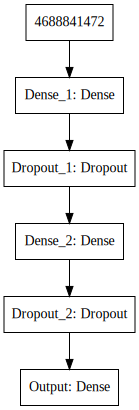

In [14]:
def getModel(dropout=0.1, neurons1=500, neurons2=250,
             learningRate=0.04):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adagrad(lr=learningRate), metrics=['accuracy'])
    return model

model1 = getModel()

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

The network was created by `getModel()` with default parameters. Method `Fit` has parameter  

`validation_split`: float (0. < x < 1): this is fraction of the data to use as hold-out validation data.  

Set `validation_split = 0.2` i.e. 20% of data will be used for validation. <br>
Fit the model and draw validation loss plot. <br>
Since we want to show validation loss behaviour after it reaches minimum, we do not use `EarlyStopping` callback.

In [15]:
net1 = model1.fit(X, y, epochs=12, batch_size=512, verbose=2,
                  validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/12
 - 1s - loss: 0.9310 - acc: 0.7144 - val_loss: 0.6000 - val_acc: 0.7665
Epoch 2/12
 - 1s - loss: 0.5506 - acc: 0.7865 - val_loss: 0.5648 - val_acc: 0.7833
Epoch 3/12
 - 1s - loss: 0.5019 - acc: 0.8044 - val_loss: 0.5417 - val_acc: 0.7880
Epoch 4/12
 - 1s - loss: 0.4682 - acc: 0.8151 - val_loss: 0.5258 - val_acc: 0.7946
Epoch 5/12
 - 1s - loss: 0.4394 - acc: 0.8253 - val_loss: 0.5271 - val_acc: 0.7913
Epoch 6/12
 - 1s - loss: 0.4146 - acc: 0.8361 - val_loss: 0.5238 - val_acc: 0.7995
Epoch 7/12
 - 1s - loss: 0.3926 - acc: 0.8453 - val_loss: 0.5115 - val_acc: 0.8049
Epoch 8/12
 - 1s - loss: 0.3713 - acc: 0.8522 - val_loss: 0.5353 - val_acc: 0.7946
Epoch 9/12
 - 1s - loss: 0.3495 - acc: 0.8592 - val_loss: 0.5440 - val_acc: 0.8029
Epoch 10/12
 - 1s - loss: 0.3323 - acc: 0.8670 - val_loss: 0.5442 - val_acc: 0.8069
Epoch 11/12
 - 1s - loss: 0.3164 - acc: 0.8730 - val_loss: 0.5358 - val_acc: 0.8057
Epoch 12/12
 - 1s - loss: 0.3018 - 

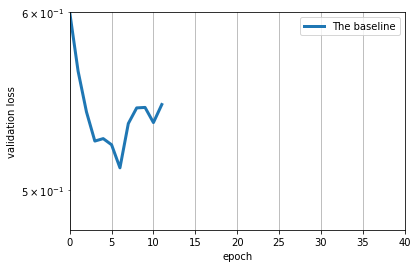

In [16]:
valid_loss1 = net1.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.48, 0.6)
plt.yscale("log")
plt.show()

Note that optimal performance is achieved around *epoch = 7*.
For later epochs the model is overfitting, and performance is worse.

# Increase dropout

Add some drop out to prevent overfitting.

In [17]:
increasedDropout = 0.4
model2 = getModel(increasedDropout)
net2 = model2.fit(X, y, epochs=12, batch_size=512, verbose=2,validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/12
 - 1s - loss: 1.0341 - acc: 0.6989 - val_loss: 0.6266 - val_acc: 0.7603
Epoch 2/12
 - 1s - loss: 0.6144 - acc: 0.7669 - val_loss: 0.5757 - val_acc: 0.7737
Epoch 3/12
 - 1s - loss: 0.5700 - acc: 0.7814 - val_loss: 0.5533 - val_acc: 0.7863
Epoch 4/12
 - 1s - loss: 0.5442 - acc: 0.7918 - val_loss: 0.5318 - val_acc: 0.7921
Epoch 5/12
 - 1s - loss: 0.5233 - acc: 0.7975 - val_loss: 0.5260 - val_acc: 0.7956
Epoch 6/12
 - 1s - loss: 0.5068 - acc: 0.8023 - val_loss: 0.5224 - val_acc: 0.7969
Epoch 7/12
 - 1s - loss: 0.4903 - acc: 0.8076 - val_loss: 0.5143 - val_acc: 0.8029
Epoch 8/12
 - 1s - loss: 0.4776 - acc: 0.8148 - val_loss: 0.5095 - val_acc: 0.8057
Epoch 9/12
 - 1s - loss: 0.4644 - acc: 0.8170 - val_loss: 0.5142 - val_acc: 0.8027
Epoch 10/12
 - 1s - loss: 0.4554 - acc: 0.8204 - val_loss: 0.5067 - val_acc: 0.8069
Epoch 11/12
 - 1s - loss: 0.4436 - acc: 0.8251 - val_loss: 0.5016 - val_acc: 0.8054
Epoch 12/12
 - 1s - loss: 0.4350 - 

Compare validation loss for `net1` and `net2`

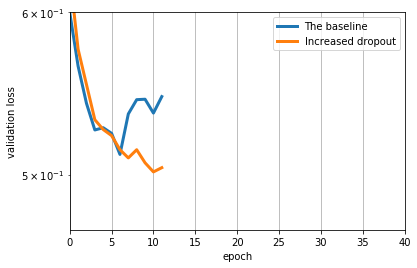

best validation loss 0.501575498685038


In [18]:
valid_loss2 = net2.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss2, linewidth=3, label="Increased dropout")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss2))

That is better. <br>
No more overfitting, and it feels like it is possible to increase number of epochs.

# Increase epoch

Increase number of epochs and check what loss can be reached.

In [19]:
model3 = getModel(increasedDropout)
net3 = model3.fit(X, y, epochs=25, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/25
 - 1s - loss: 1.0341 - acc: 0.6989 - val_loss: 0.6266 - val_acc: 0.7603
Epoch 2/25
 - 1s - loss: 0.6144 - acc: 0.7669 - val_loss: 0.5757 - val_acc: 0.7737
Epoch 3/25
 - 1s - loss: 0.5700 - acc: 0.7814 - val_loss: 0.5533 - val_acc: 0.7863
Epoch 4/25
 - 1s - loss: 0.5442 - acc: 0.7918 - val_loss: 0.5318 - val_acc: 0.7924
Epoch 5/25
 - 1s - loss: 0.5233 - acc: 0.7976 - val_loss: 0.5255 - val_acc: 0.7955
Epoch 6/25
 - 1s - loss: 0.5069 - acc: 0.8023 - val_loss: 0.5219 - val_acc: 0.7979
Epoch 7/25
 - 1s - loss: 0.4901 - acc: 0.8073 - val_loss: 0.5136 - val_acc: 0.8028
Epoch 8/25
 - 1s - loss: 0.4776 - acc: 0.8144 - val_loss: 0.5083 - val_acc: 0.8050
Epoch 9/25
 - 1s - loss: 0.4649 - acc: 0.8177 - val_loss: 0.5126 - val_acc: 0.8027
Epoch 10/25
 - 1s - loss: 0.4552 - acc: 0.8199 - val_loss: 0.5086 - val_acc: 0.8059
Epoch 11/25
 - 1s - loss: 0.4430 - acc: 0.8253 - val_loss: 0.5025 - val_acc: 0.8055
Epoch 12/25
 - 1s - loss: 0.4353 - 

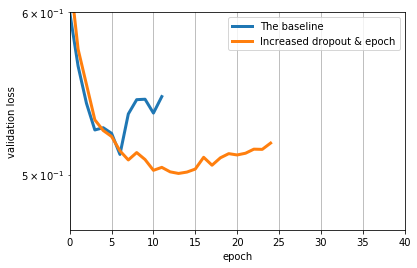

best validation loss 0.5007042589576738


In [20]:
valid_loss3 = np.array(net3.history["val_loss"])
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss3))

Try to improve performance further by adding neurons

# Increase number of neurons

Increase number of neurons in the first hidden layer.

In [21]:
increasedNeurons1 = 1000
model4 = getModel(increasedDropout, neurons1=increasedNeurons1)
net4 = model4.fit(X, y, epochs=25, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/25
 - 2s - loss: 5.7394 - acc: 0.4995 - val_loss: 0.6476 - val_acc: 0.7594
Epoch 2/25
 - 1s - loss: 0.6297 - acc: 0.7627 - val_loss: 0.5790 - val_acc: 0.7769
Epoch 3/25
 - 1s - loss: 0.5708 - acc: 0.7807 - val_loss: 0.5410 - val_acc: 0.7904
Epoch 4/25
 - 1s - loss: 0.5340 - acc: 0.7943 - val_loss: 0.5322 - val_acc: 0.7913
Epoch 5/25
 - 1s - loss: 0.5094 - acc: 0.8030 - val_loss: 0.5223 - val_acc: 0.7963
Epoch 6/25
 - 1s - loss: 0.4888 - acc: 0.8113 - val_loss: 0.5145 - val_acc: 0.8008
Epoch 7/25
 - 1s - loss: 0.4680 - acc: 0.8163 - val_loss: 0.5032 - val_acc: 0.8059
Epoch 8/25
 - 1s - loss: 0.4502 - acc: 0.8220 - val_loss: 0.5015 - val_acc: 0.8066
Epoch 9/25
 - 1s - loss: 0.4374 - acc: 0.8271 - val_loss: 0.5094 - val_acc: 0.8048
Epoch 10/25
 - 1s - loss: 0.4229 - acc: 0.8325 - val_loss: 0.5084 - val_acc: 0.8076
Epoch 11/25
 - 1s - loss: 0.4086 - acc: 0.8366 - val_loss: 0.4961 - val_acc: 0.8122
Epoch 12/25
 - 1s - loss: 0.3951 - 

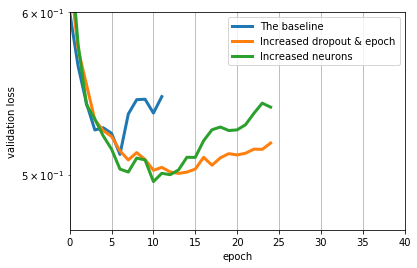

best validation loss 0.49614772646445926


In [22]:
valid_loss4 = net4.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss4))

That is better, but we start overfitting around epoch 12. <br>

# Decrease learning rate

To prevent overfitting decrease the learning rate.

In [23]:
model5 = getModel(increasedDropout, neurons1=increasedNeurons1, learningRate=0.008)
net5 = model5.fit(X, y, epochs=30, batch_size=512, verbose=2, validation_split=0.2)

Train on 44702 samples, validate on 11176 samples
Epoch 1/30
 - 2s - loss: 0.7756 - acc: 0.7183 - val_loss: 0.6112 - val_acc: 0.7734
Epoch 2/30
 - 1s - loss: 0.6081 - acc: 0.7686 - val_loss: 0.5770 - val_acc: 0.7805
Epoch 3/30
 - 2s - loss: 0.5775 - acc: 0.7782 - val_loss: 0.5596 - val_acc: 0.7834
Epoch 4/30
 - 1s - loss: 0.5548 - acc: 0.7873 - val_loss: 0.5511 - val_acc: 0.7870
Epoch 5/30
 - 1s - loss: 0.5386 - acc: 0.7919 - val_loss: 0.5402 - val_acc: 0.7912
Epoch 6/30
 - 1s - loss: 0.5299 - acc: 0.7959 - val_loss: 0.5362 - val_acc: 0.7907
Epoch 7/30
 - 2s - loss: 0.5170 - acc: 0.8003 - val_loss: 0.5291 - val_acc: 0.7948
Epoch 8/30
 - 2s - loss: 0.5073 - acc: 0.8023 - val_loss: 0.5245 - val_acc: 0.7953
Epoch 9/30
 - 1s - loss: 0.4996 - acc: 0.8056 - val_loss: 0.5275 - val_acc: 0.7963
Epoch 10/30
 - 2s - loss: 0.4931 - acc: 0.8094 - val_loss: 0.5199 - val_acc: 0.7991
Epoch 11/30
 - 1s - loss: 0.4834 - acc: 0.8135 - val_loss: 0.5147 - val_acc: 0.7998
Epoch 12/30
 - 2s - loss: 0.4775 - 

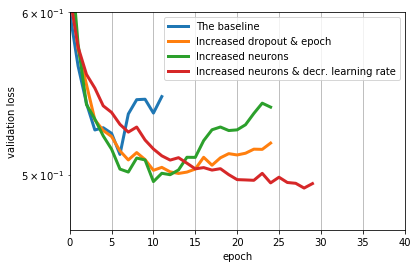

best validation loss 0.4925565438007745


In [25]:
valid_loss5 = net5.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.plot(valid_loss5, linewidth=3, label="Increased neurons & decr. learning rate")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.6)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss5))

Low learning rate smoothed down validation loss curve and improved prediction quality. 
Now there is a good balance between number of neurons, dropout and learning rate. <br>
Note that other parameters could have been tuned too: number of layers, activation function etc.

<font color=blue>
    
**Assignment 1**  <br>
Tune sequentially droput rate, number of epochs and number of neurons of the following network:

![test_model6](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2Ftest_model6.png)

Try to improve 'best validation loss' at least by 0.02 compare to starting point (dropout rate = 0, optimizer=Adagrad(lr=0.04). <br>
Do not change validation_split=0.2, optimizer and learning rate. 

![TunningPic1](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FLecture%207%20AdvML%2FTunningPic1.png)

In [ ]:
#Skipped code
# Assignment 1


# Tuning hyperparameters with grid search

Keras sequential models (single-input only) can be used in `scikit-learn` by wrapping them with the `KerasClassifier` or `KerasRegressor` class.

To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the `build_fn` argument when constructing the `KerasClassifier` class. `build_fn` should construct, compile and return a Keras model, which will then be used to fit/predict. One of the following three values could be passed to build_fn:  

- A function
- An instance of a class that implements the call method
- None. This means you implement a class that inherits from either KerasClassifier or KerasRegressor. The call method of the present class will then be treated as the default *build_fn*.

E.g. we can create `KerasClassifier` instance with the above defined function `getModel` :

In [27]:
model = KerasClassifier(build_fn=getModel)

The constructor for the KerasClassifier class takes second argument   
`ssk_params`: model parameters & fitting parameters.  
We can pass there any legal model and fitting parameters. 

In [28]:
model = KerasClassifier(build_fn=getModel, epochs=20, batch_size=512, verbose=0)
model.get_params()

{'epochs': 20,
 'batch_size': 512,
 'verbose': 0,
 'build_fn': <function __main__.getModel(dropout=0.1, neurons1=500, neurons2=250, learningRate=0.04)>}

Since it is now scikit-learn Classifier, we can use Grid search - a model hyperparameter optimization technique provided in scikit-learn GridSearchCV class.  

When constructing this class we provide a dictionary of hyperparameters to evaluate in the `param_grid` argument.

By default, the grid search will only use one thread. <br>
By setting the `n_jobs` argument in the `GridSearchCV` constructor to -1, the process will use all cores on your machine. <br>
If `n_jobs` was set to a value higher than one, the data are copied for each point in the grid (and not `n_jobs` times). <br>
This is done for efficiency if individual jobs take very little time, but may raise errors if the dataset is large and there is not enough memory available. <br>
A workaround in this case is to set pre_dispatch. <br>
Then, the memory is copied only pre_dispatch many times. <br>
A reasonable value for pre_dispatch is $2~\times~$n_jobs.

The `GridSearchCV` process will then construct and evaluate one model for each combination of parameters. <br>
Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the `GridSearchCV` constructor.  

We set "neg_log_loss" (negative logloss) as a scoring measure since  `GridSearchCV` is trying to maximize score.

In [29]:
# define the grid search parameters
param_grid = dict(dropout=[0.1, 0.2, 0.3], neurons1=[300, 500, 700])

grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring="neg_log_loss", n_jobs=1)


In [31]:
grid_result = grid.fit(X, y)

/Users/joshuagoldberg/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


We can extract results from `grid_result` attribute `cv_results_`. 

Recall that we were maximizing negative logloss. So, we output `-mean`  as logloss mean.

In [32]:
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))


Best: 0.524630 using {'dropout': 0.3, 'neurons1': 300}
0.604970 (0.009914) with: {'dropout': 0.1, 'neurons1': 300}
0.663719 (0.008542) with: {'dropout': 0.1, 'neurons1': 500}
0.672649 (0.006981) with: {'dropout': 0.1, 'neurons1': 700}
0.554974 (0.007766) with: {'dropout': 0.2, 'neurons1': 300}
0.583003 (0.004900) with: {'dropout': 0.2, 'neurons1': 500}
0.600827 (0.007651) with: {'dropout': 0.2, 'neurons1': 700}
0.524630 (0.005670) with: {'dropout': 0.3, 'neurons1': 300}
0.543552 (0.003182) with: {'dropout': 0.3, 'neurons1': 500}
0.545685 (0.006487) with: {'dropout': 0.3, 'neurons1': 700}


# Selecting Optimization Algorithm

Grid search may be applied not only to numerical parameters. 

We can find the best optimizer using it.

In [33]:
def getModel1(dropout=0.1, neurons1=500, neurons2=250,optimizer="Adagrad"):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features))
    model.add(Dropout(dropout))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# create model
model = KerasClassifier(build_fn=getModel1, dropout=0.3, neurons1=300,
                        epochs=20, batch_size=512, verbose=0)
# define the grid search parameters

grid = GridSearchCV(estimator=model, param_grid=dict(optimizer=optimizer),
                    scoring="neg_log_loss",n_jobs=1)


In [23]:
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.512019 using {'optimizer': 'Adam'}
0.746024 (0.002902) with: {'optimizer': 'SGD'}
0.515591 (0.002480) with: {'optimizer': 'RMSprop'}
0.522140 (0.002009) with: {'optimizer': 'Adagrad'}
0.519864 (0.001241) with: {'optimizer': 'Adadelta'}
0.512019 (0.002401) with: {'optimizer': 'Adam'}
0.518393 (0.001063) with: {'optimizer': 'Adamax'}
0.522720 (0.004061) with: {'optimizer': 'Nadam'}
